# Modelo de predição de preço de laptops

Os dados foram obtidos no dataset de Anubhal Goyal, disponibilizando no Kaggle por meio deste [link](https://www.kaggle.com/datasets/anubhavgoyal10/laptop-prices-dataset).
O arquivo original já foi baixado na pasta ```data/raw```

In [27]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

import xgboost as xgb


%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [28]:
np.__version__

'1.25.2'

In [29]:
df = pd.read_csv("../data/raw/laptopPrice.csv")
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


## Pré-processamento

Padronização dos dados, consistindo nas etapas de:

* Padronização de caixa baixa
* Transformação de valores _string_ para _long_
* Transformação e criação de novos features

In [30]:
df_transformed = df.copy()

df_transformed = df_transformed.astype(str).apply(lambda x: x.str.lower())

In [31]:
df_transformed.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,asus,intel,core i3,10th,4 gb,ddr4,0 gb,1024 gb,windows,64-bit,0 gb,casual,no warranty,no,no,34649,2 stars,3,0
1,lenovo,intel,core i3,10th,4 gb,ddr4,0 gb,1024 gb,windows,64-bit,0 gb,casual,no warranty,no,no,38999,3 stars,65,5
2,lenovo,intel,core i3,10th,4 gb,ddr4,0 gb,1024 gb,windows,64-bit,0 gb,casual,no warranty,no,no,39999,3 stars,8,1
3,asus,intel,core i5,10th,8 gb,ddr4,512 gb,0 gb,windows,32-bit,2 gb,casual,no warranty,no,no,69990,3 stars,0,0
4,asus,intel,celeron dual,not available,4 gb,ddr4,0 gb,512 gb,windows,64-bit,0 gb,casual,no warranty,no,no,26990,3 stars,0,0


As colunas a seguir não deverão ser utilizadas pois elas não conseguem ser simuladas por um serviço projetado da qual o usuário irá fornecer as características para a simulação do preço do laptop.

In [32]:
df_transformed.drop("rating", axis=1, inplace=True)
df_transformed.drop("Number of Ratings", axis=1, inplace=True)
df_transformed.drop("Number of Reviews", axis=1, inplace=True)
df_transformed.drop("msoffice", axis=1, inplace=True)
df_transformed.drop("processor_gnrtn", axis=1, inplace=True)

Ajustando os dados para remover e adaptar conteúdos _string_ para _numeric_.

In [33]:
df_transformed['ram_gb'] = df_transformed['ram_gb'].replace({' gb' : ''}, regex=True)
df_transformed['ssd'] = df_transformed['ssd'].replace({' gb' : ''}, regex=True)
df_transformed['hdd'] = df_transformed['hdd'].replace({' gb' : ''}, regex=True)
df_transformed['graphic_card_gb'] = df_transformed['ram_gb'].replace({' gb' : ''}, regex=True)
df_transformed['warranty'] = df_transformed['warranty'].replace({'no warranty' : '0'}, regex=True)
df_transformed['warranty'] = df_transformed['warranty'].replace({' (years|year)' : ''}, regex=True)
df_transformed['Touchscreen'] = df_transformed['Touchscreen'].replace({'no' : '0'}, regex=True)
df_transformed['Touchscreen'] = df_transformed['Touchscreen'].replace({'yes' : '1'}, regex=True)

In [34]:
df_transformed = df_transformed.rename(columns={"Touchscreen": "touchscreen","Price": "price"})

In [35]:
df_transformed.head()

,brand,processor_brand,processor_name,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,touchscreen,price
0,asus,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,34649
1,lenovo,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,38999
2,lenovo,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,39999
3,asus,intel,core i5,8,ddr4,512,0,windows,32-bit,8,casual,0,0,69990
4,asus,intel,celeron dual,4,ddr4,0,512,windows,64-bit,4,casual,0,0,26990


Convertendo os tipos de dados para cada coluna, convertendo os tipos adequados, ou seja, valores numéricos deverão ser convertidos para inteiro.

In [36]:
df_transformed['ram_gb'] = pd.to_numeric(df_transformed['ram_gb'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['hdd'] = pd.to_numeric(df_transformed['hdd'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['ssd'] = pd.to_numeric(df_transformed['ssd'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['graphic_card_gb'] = pd.to_numeric(df_transformed['graphic_card_gb'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['warranty'] = pd.to_numeric(df_transformed['warranty'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['price'] = pd.to_numeric(df_transformed['price'], errors='coerce').fillna(0).astype(np.float64)
df_transformed['touchscreen'] = pd.to_numeric(df_transformed['touchscreen'], errors='coerce').fillna(0).astype(np.int64)
df_transformed['price'] = pd.to_numeric(df_transformed['price'], errors='coerce').fillna(0).astype(np.int64)

Diminuir a quantidade de itens para tornar o modelo mais simples e balancear os dados.

In [37]:
df_transformed["processor_name"].unique()

array(['core i3', 'core i5', 'celeron dual', 'ryzen 5', 'core i7',
       'core i9', 'm1', 'pentium quad', 'ryzen 3', 'ryzen 7', 'ryzen 9'],
      dtype=object)

In [38]:
df_transformed["os"].unique()

array(['windows', 'dos', 'mac'], dtype=object)

In [39]:
df_transformed["processor_name"].unique()

array(['core i3', 'core i5', 'celeron dual', 'ryzen 5', 'core i7',
       'core i9', 'm1', 'pentium quad', 'ryzen 3', 'ryzen 7', 'ryzen 9'],
      dtype=object)

In [40]:
df_transformed["ram_type"].unique()

array(['ddr4', 'lpddr4', 'lpddr4x', 'ddr5', 'ddr3', 'lpddr3'],
      dtype=object)

In [41]:
df_transformed["weight"].unique()

array(['casual', 'thinnlight', 'gaming'], dtype=object)

In [42]:
replace_dict = {'mac': 'other', 'dos': 'other'}
df_transformed['os'].replace(replace_dict, inplace=True)

replace_dict = {'lpddr4x': 'other', 'lpddr4': 'other', 'lpddr3': 'other','ddr5':'other','ddr3':'other'}
df_transformed['ram_type'].replace(replace_dict, inplace=True)

replace_dict = {'core i9': 'other', 'pentium quad': 'other', 'm1': 'other','celeron dual':'other','ryzen 9':'other','ryzen 3':'ryzen 7'}
df_transformed['processor_name'].replace(replace_dict, inplace=True)

replace_dict = {'acer': 'other', 'msi': 'other', 'apple': 'other','avita':'other'}
df_transformed['brand'].replace(replace_dict, inplace=True)

Remover itens duplicados.

In [43]:
df_transformed.drop_duplicates(inplace=True)

In [44]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779 entries, 0 to 822
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            779 non-null    object
 1   processor_brand  779 non-null    object
 2   processor_name   779 non-null    object
 3   ram_gb           779 non-null    int64 
 4   ram_type         779 non-null    object
 5   ssd              779 non-null    int64 
 6   hdd              779 non-null    int64 
 7   os               779 non-null    object
 8   os_bit           779 non-null    object
 9   graphic_card_gb  779 non-null    int64 
 10  weight           779 non-null    object
 11  warranty         779 non-null    int64 
 12  touchscreen      779 non-null    int64 
 13  price            779 non-null    int64 
dtypes: int64(7), object(7)
memory usage: 91.3+ KB


In [45]:
df_transformed

,brand,processor_brand,processor_name,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,touchscreen,price
0,asus,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,34649
1,lenovo,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,38999
2,lenovo,intel,core i3,4,ddr4,0,1024,windows,64-bit,4,casual,0,0,39999
3,asus,intel,core i5,8,ddr4,512,0,windows,32-bit,8,casual,0,0,69990
4,asus,intel,other,4,ddr4,0,512,windows,64-bit,4,casual,0,0,26990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,asus,amd,other,4,ddr4,1024,0,windows,64-bit,4,casual,1,0,135990
819,asus,amd,other,4,ddr4,1024,0,windows,64-bit,4,casual,1,0,144990
820,asus,amd,other,4,ddr4,1024,0,windows,64-bit,4,casual,1,0,149990
821,asus,amd,other,4,ddr4,1024,0,windows,64-bit,4,casual,1,0,142990


Criando atributos one hot enconded.

In [46]:
df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["brand"], prefix="brand")
df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["processor_brand"], prefix="processor_brand")
df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["processor_name"], prefix="processor_name")

df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["os"], prefix="os")
df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["weight"], prefix="weight")
#df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["warranty"], prefix="warranty")
df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["touchscreen"], prefix="touchscreen")
#df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["ram_gb"], prefix="ram_gb")

#df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["hdd"], prefix="hdd")
#df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["ssd"], prefix="ssd")

#df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["graphic_card_gb"], prefix="graphic_card_gb")
df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["ram_type"], prefix="ram_type")

df_transformed = pd.get_dummies(df_transformed, dtype=int, columns=["os_bit"], prefix="os_bit")

Criando atributos categóricos baseados em números.

In [47]:
df_transformed

,ram_gb,ssd,hdd,graphic_card_gb,warranty,price,brand_asus,brand_dell,brand_hp,brand_lenovo,...,os_windows,weight_casual,weight_gaming,weight_thinnlight,touchscreen_0,touchscreen_1,ram_type_ddr4,ram_type_other,os_bit_32-bit,os_bit_64-bit
0,4,0,1024,4,0,34649,1,0,0,0,...,1,1,0,0,1,0,1,0,0,1
1,4,0,1024,4,0,38999,0,0,0,1,...,1,1,0,0,1,0,1,0,0,1
2,4,0,1024,4,0,39999,0,0,0,1,...,1,1,0,0,1,0,1,0,0,1
3,8,512,0,8,0,69990,1,0,0,0,...,1,1,0,0,1,0,1,0,1,0
4,4,0,512,4,0,26990,1,0,0,0,...,1,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,4,1024,0,4,1,135990,1,0,0,0,...,1,1,0,0,1,0,1,0,0,1
819,4,1024,0,4,1,144990,1,0,0,0,...,1,1,0,0,1,0,1,0,0,1
820,4,1024,0,4,1,149990,1,0,0,0,...,1,1,0,0,1,0,1,0,0,1
821,4,1024,0,4,1,142990,1,0,0,0,...,1,1,0,0,1,0,1,0,0,1


## Treinamento

Dado o objetivo de estimar o valor do notebook com base nos atributos fornecidos, vamos resolver com algoritmos de regressão.

In [48]:
features = list(df_transformed.columns)

features.remove("price")

features

['ram_gb',
 'ssd',
 'hdd',
 'graphic_card_gb',
 'warranty',
 'brand_asus',
 'brand_dell',
 'brand_hp',
 'brand_lenovo',
 'brand_other',
 'processor_brand_amd',
 'processor_brand_intel',
 'processor_brand_m1',
 'processor_name_core i3',
 'processor_name_core i5',
 'processor_name_core i7',
 'processor_name_other',
 'processor_name_ryzen 5',
 'processor_name_ryzen 7',
 'os_other',
 'os_windows',
 'weight_casual',
 'weight_gaming',
 'weight_thinnlight',
 'touchscreen_0',
 'touchscreen_1',
 'ram_type_ddr4',
 'ram_type_other',
 'os_bit_32-bit',
 'os_bit_64-bit']

In [49]:
X = df_transformed[features]

X

,ram_gb,ssd,hdd,graphic_card_gb,warranty,brand_asus,brand_dell,brand_hp,brand_lenovo,brand_other,...,os_windows,weight_casual,weight_gaming,weight_thinnlight,touchscreen_0,touchscreen_1,ram_type_ddr4,ram_type_other,os_bit_32-bit,os_bit_64-bit
0,4,0,1024,4,0,1,0,0,0,0,...,1,1,0,0,1,0,1,0,0,1
1,4,0,1024,4,0,0,0,0,1,0,...,1,1,0,0,1,0,1,0,0,1
2,4,0,1024,4,0,0,0,0,1,0,...,1,1,0,0,1,0,1,0,0,1
3,8,512,0,8,0,1,0,0,0,0,...,1,1,0,0,1,0,1,0,1,0
4,4,0,512,4,0,1,0,0,0,0,...,1,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,4,1024,0,4,1,1,0,0,0,0,...,1,1,0,0,1,0,1,0,0,1
819,4,1024,0,4,1,1,0,0,0,0,...,1,1,0,0,1,0,1,0,0,1
820,4,1024,0,4,1,1,0,0,0,0,...,1,1,0,0,1,0,1,0,0,1
821,4,1024,0,4,1,1,0,0,0,0,...,1,1,0,0,1,0,1,0,0,1


In [50]:
y = df_transformed["price"]
y

0       34649
1       38999
2       39999
3       69990
4       26990
        ...  
818    135990
819    144990
820    149990
821    142990
822     57490
Name: price, Length: 779, dtype: int64

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)

Implementando XGBoost

In [53]:
regressor=xgb.XGBRegressor(eval_metric='mae')

param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700, 1500],
              "learning_rate": [0.01, 0.05]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 700}


In [54]:
model = xgb.XGBRegressor(learning_rate = 0.01,
                           n_estimators  = 700,
                           max_depth     = 4,
                           eval_metric='mae')

model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2: {r2}')

Mean Squared Error: 677847648.2072302
Mean Absolute Error: 14607.7841796875
R2: 0.6402502200170211


In [50]:
X.columns

Index(['brand_asus', 'brand_dell', 'brand_hp', 'brand_lenovo', 'brand_other',
       'processor_brand_amd', 'processor_brand_intel', 'processor_brand_m1',
       'processor_name_core i3', 'processor_name_core i5',
       'processor_name_core i7', 'processor_name_other',
       'processor_name_ryzen 5', 'processor_name_ryzen 7', 'os_other',
       'os_windows', 'weight_casual', 'weight_gaming', 'weight_thinnlight',
       'warranty_0', 'warranty_1', 'warranty_2', 'warranty_3', 'touchscreen_0',
       'touchscreen_1', 'ram_gb_4', 'ram_gb_8', 'ram_gb_16', 'ram_gb_32',
       'hdd_0', 'hdd_512', 'hdd_1024', 'hdd_2048', 'ssd_0', 'ssd_128',
       'ssd_256', 'ssd_512', 'ssd_1024', 'ssd_2048', 'ssd_3072',
       'graphic_card_gb_4', 'graphic_card_gb_8', 'graphic_card_gb_16',
       'graphic_card_gb_32', 'ram_type_ddr4', 'ram_type_other',
       'os_bit_32-bit', 'os_bit_64-bit'],
      dtype='object')

In [55]:
len(X.columns)

30

In [61]:
data = {
    "brand": "dell",
    "processor_brand": "intel",
    "processor_name": "core i5",
    "os": "windows",
    "weight": "casual",
    "warranty": "3",
    "touchscreen": "0",
    "ram_gb": "16",
    "hdd": "0",
    "ssd": "256",
    "graphic_card": "4",
    "ram_type": "ddr4",
    "os_bit": "64"
}

data_processed=[]



data_processed.append(int(data["ram_gb"]))
data_processed.append(int(data["ssd"]))
data_processed.append(int(data["hdd"]))
data_processed.append(int(data["graphic_card"]))
data_processed.append(int(data["warranty"]))

data_processed.append(1) if data["brand"] == "asus" else data_processed.append(0)
data_processed.append(1) if data["brand"] == "dell" else data_processed.append(0)
data_processed.append(1) if data["brand"] == "hp" else data_processed.append(0)
data_processed.append(1) if data["brand"] == "lenovo" else data_processed.append(0)
data_processed.append(1) if data["brand"] == "other" else data_processed.append(0)

data_processed.append(1) if data["processor_brand"] == "amd" else data_processed.append(0)
data_processed.append(1) if data["processor_brand"] == "intel" else data_processed.append(0)
data_processed.append(1) if data["processor_brand"] == "m1" else data_processed.append(0)

data_processed.append(1) if data["processor_name"] == "core i3" else data_processed.append(0)
data_processed.append(1) if data["processor_name"] == "core i5" else data_processed.append(0)
data_processed.append(1) if data["processor_name"] == "core i7" else data_processed.append(0)
data_processed.append(1) if data["processor_name"] == "other" else data_processed.append(0)
data_processed.append(1) if data["processor_name"] == "ryzen 5" else data_processed.append(0)
data_processed.append(1) if data["processor_name"] == "ryzen 7" else data_processed.append(0)

data_processed.append(1) if data["os"] == "other" else data_processed.append(0)
data_processed.append(1) if data["os"] == "windows" else data_processed.append(0)

data_processed.append(1) if data["weight"] == "casual" else data_processed.append(0)
data_processed.append(1) if data["weight"] == "gaming" else data_processed.append(0)
data_processed.append(1) if data["weight"] == "thinnlight" else data_processed.append(0)

data_processed.append(1) if data["touchscreen"] == "0" else data_processed.append(0)
data_processed.append(1) if data["touchscreen"] == "1" else data_processed.append(0)

data_processed.append(1) if data["ram_type"] == "ddr4" else data_processed.append(0)
data_processed.append(1) if data["ram_type"] == "other" else data_processed.append(0)

data_processed.append(1) if data["os_bit"] == "32" else data_processed.append(0)
data_processed.append(1) if data["os_bit"] == "64" else data_processed.append(0)

In [57]:
dados_inferencia = np.array(data_processed).reshape(1, -1)
dados_inferencia

array([[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1]])

In [64]:
result = model.predict([data_processed])
result[0]

76443.875

In [37]:
%matplotlib widget

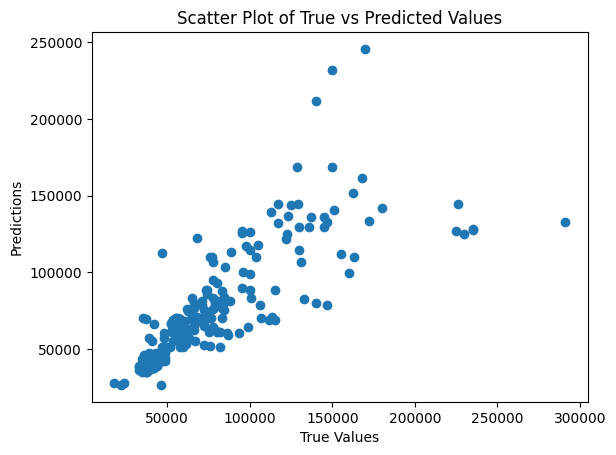

In [55]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot of True vs Predicted Values')
plt.show()